In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from numpy.fft import fft,fftshift
plt.rcParams.update({'font.size': 16})

In [13]:
%matplotlib notebook
cmap=plt.get_cmap('seismic')

In [4]:
SW=200
TD=640
SI=2048
SF=150
O=100


SWH=SF*SW
dt=1/SWH

artifacts=.03*(1)

In [5]:
A,delta1,lw1,delta2,lw2=[[] for _ in range(5)]
with open('peaks.txt','r') as f:
    for line in f:
        i,d1,l1,d2,l2=[float(x) for x in line.strip().split('\t')]
        A.append(i)
        delta1.append(d1)
        lw1.append(l1)
        delta2.append(d2)
        lw2.append(l2)
A,delta1,lw1,delta2,lw2=[np.array(x) for x in [A,delta1,lw1,delta2,lw2]]


vr=12000
i=np.logical_and(delta1>140,delta2>140)
A=np.concatenate([A,.1*A[i],.1*A[i],.03*A[i],.03*A[i],.03*A[i]])
delta1=np.concatenate([delta1,delta1[i],delta1[i]-vr/SF,delta1[i],delta1[i]-2*vr/SF,delta1[i]-vr/SF])
delta2=np.concatenate([delta2,delta2[i]-vr/SF,delta2[i],delta2[i]-2*vr/SF,delta2[i],delta2[i]-vr/SF])
lw1=np.concatenate([lw1,lw1[i],lw1[i],lw1[i],lw1[i],lw1[i]])
lw2=np.concatenate([lw2,lw2[i],lw2[i],lw2[i],lw2[i],lw2[i]])


nl=A.max()/3

In [7]:
t=np.arange(TD)*dt

RR,RI,IR,II=[np.zeros((TD,TD),dtype=complex) for _ in range(4)]

for i,d1,l1,d2,l2 in zip(A,delta1,lw1,delta2,lw2):
    RR+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T.real*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).real)
    RI+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T.imag*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).real)
    IR+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T.real*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).imag)
    II+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T.imag*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).imag)

In [8]:
S=[]
apod=np.cos(np.arange(TD)/TD*np.pi/2)**2

for I,p,q in zip([RR,RI,IR,II],[1,1j,1,1j],[1,1,1j,1j]):    
    I_a=((I*apod).T*apod).T*p
    I_a[0]/=2

    S0=fft(I_a.T,SI)
    S0[0]/=2

    S.append(fftshift(fft(S0.real.T*q,SI)).real)

f=1/(2*dt)*np.linspace(-1,1,SI)
f-=np.diff(f[:2])/2

<IPython.core.display.Javascript object>


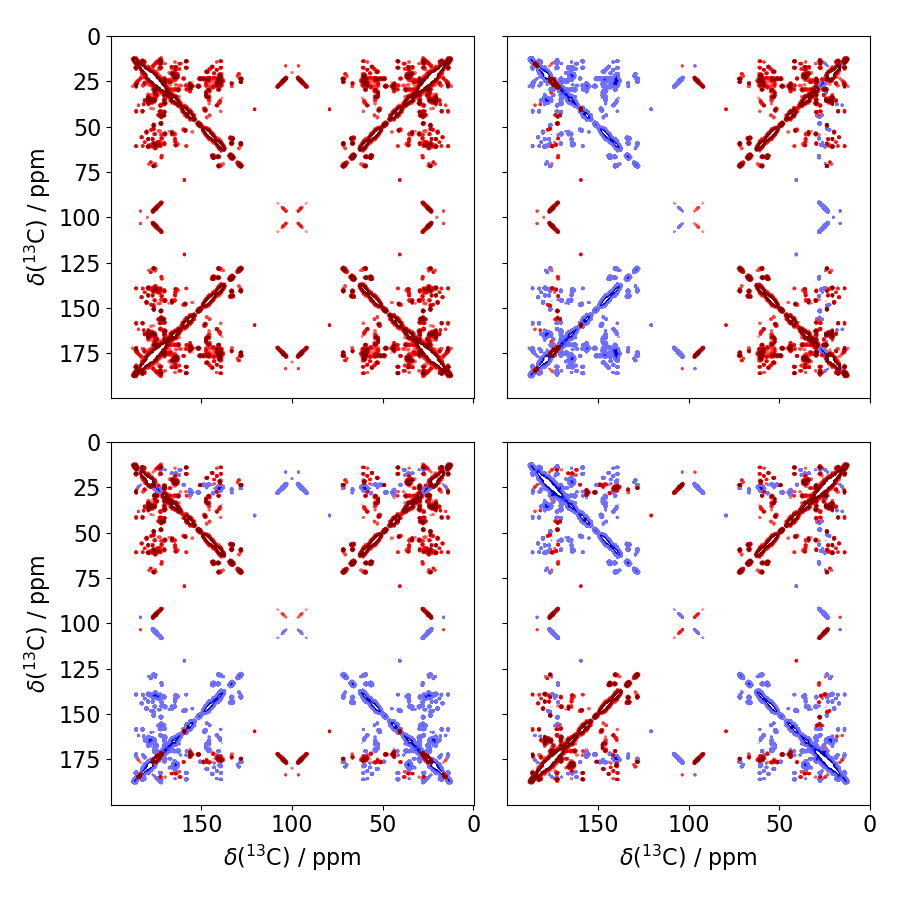

/Users/albertsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/albertsmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  from ipykernel import kernelapp as app


In [14]:
fig,ax=plt.subplots(2,2)
ax=ax.flatten()
levels=np.logspace(np.log10(S[0].max()*A.min()/A.max()*3),np.log10(S[0].max()/50),25)
levels=np.concatenate([-levels[::-1],levels])
for S0,a in zip(S,ax):
    a.contour(f/SF+O,f/SF+O,S0.real.T,levels,cmap=cmap)
    a.invert_xaxis()
    a.invert_yaxis()
    a.set_aspect('equal', 'box')

    if a.is_last_row():
        a.set_xlabel(r'$\delta$($^{13}$C) / ppm')
    else:
        a.set_xticklabels('')
    if a.is_first_col():
        a.set_ylabel(r'$\delta$($^{13}$C) / ppm')
    else:
        a.set_yticklabels('')
fig.set_size_inches([9,9])
fig.tight_layout()

<IPython.core.display.Javascript object>


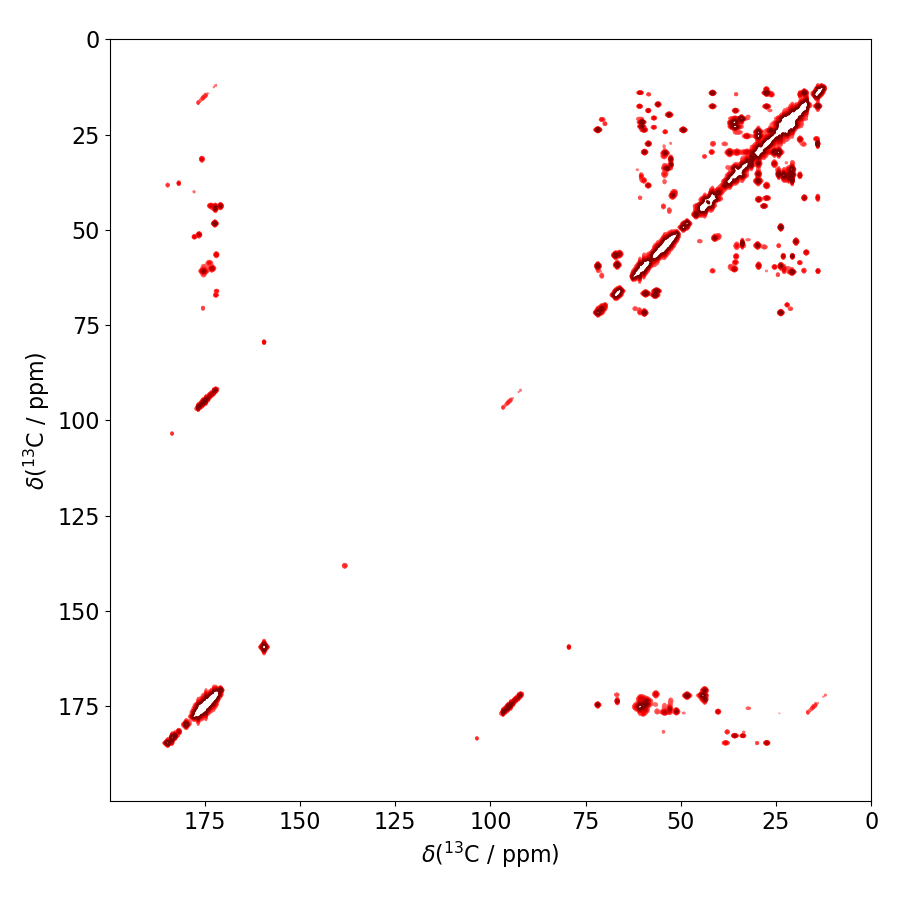

In [15]:
fig,ax=plt.subplots()
ax.contour(f/SF+O,f/SF+O,np.sum(S,axis=0).real.T,levels*4,cmap=cmap)
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel(r'$\delta$($^{13}$C / ppm)')
ax.set_ylabel(r'$\delta$($^{13}$C / ppm)')
ax.set_aspect('equal', 'box')
fig.set_size_inches([9,9])
fig.tight_layout()